# Load and plot particle data from HZDR cloud(the first given data)

In [15]:
import openpmd_api as io
import numpy as np

print("openPMD-api: {}"
      .format(io.__version__))
print("openPMD-api backend variants: {}"
      .format(io.variants))

openPMD-api: 0.14.5
openPMD-api backend variants: {'adios1': True, 'adios2': True, 'hdf5': True, 'json': True, 'mpi': False}


### Discover structure of openPMD file with phase space data

In [16]:
series = io.Series("../from_cloud/simData_68500.bp",
                       io.Access.read_only)
print("Read a Series with openPMD standard version %s" %
      series.openPMD)

print("The Series contains {0} iterations:".format(len(series.iterations)))
for i in series.iterations:
    print("\t {0}".format(i))
print("")

Read a Series with openPMD standard version 1.1.0
The Series contains 1 iterations:
	 68500



In [17]:
i = series.iterations[68500]
print("Iteration 68500 contains {0} meshes:".format(len(i.meshes)))
for m in i.meshes:
    print("\t {0}".format(m))
print("")
print("Iteration 68500 contains {0} particle species:".format(
    len(i.particles)))
for ps in i.particles:
    print("\t {0}".format(ps))
    print("With records:")
    for r in i.particles[ps]:
        print("\t {0}".format(r))

Iteration 68500 contains 1 meshes:
	 picongpu_idProvider

Iteration 68500 contains 1 particle species:
	 b_all
With records:
	 charge
	 mass
	 momentum
	 momentumPrev1
	 position
	 positionOffset
	 radiationMask
	 weighting


In [18]:
electrons = i.particles["b_all"]
charge = electrons["charge"][io.Mesh_Record_Component.SCALAR]
#charge = charge[0:7]
#charge = electrons["charge"]
series.flush()
for a in charge.attributes:
    print("    {0}".format(a))
print(charge.get_attribute('shape'))
print("And the first electron particle has a charge {}"
      .format(charge.get_attribute('value')))
print("")
del charge

    macroWeighted
    shape
    timeOffset
    unitDimension
    unitSI
    value
    weightingPower
345007
And the first electron particle has a charge -0.0015508142532780766



### Extract positions and momenta of particles in phase space as a numpy array of shape (number of particles, 6)

In [19]:
particles = i.particles["b_all"]

num_particles = -1
    
x_pos = particles["position"]["x"][:num_particles]
y_pos = particles["position"]["y"][:num_particles]
z_pos = particles["position"]["z"][:num_particles]
x_pos_offset = particles["positionOffset"]["x"][:num_particles]
y_pos_offset = particles["positionOffset"]["y"][:num_particles]
z_pos_offset = particles["positionOffset"]["z"][:num_particles]

x_momentum = particles["momentum"]["x"][:num_particles]
y_momentum = particles["momentum"]["y"][:num_particles]
z_momentum = particles["momentum"]["z"][:num_particles]

series.flush()

particle_tensor = np.stack((x_pos+x_pos_offset,
                            y_pos+y_pos_offset,
                            z_pos+z_pos_offset,
                            x_momentum,
                            y_momentum,
                            z_momentum), axis=-1)
    


In [20]:
print(particle_tensor.shape)

print(particle_tensor[0,:])

(345006, 6)
[ 3.53481165e+02  4.55840437e+02  3.72121932e+01  1.65532704e-03
  1.54562492e+01 -2.09832415e-01]


### Normalize each column between 0 and 1

In [21]:
for i in range(particle_tensor.shape[1]):
    minv = np.min(particle_tensor[:,i])
    maxv = np.max(particle_tensor[:,i])
    particle_tensor[:,i] = (particle_tensor[:,i]-minv)/(maxv-minv)

## Plot particle data

### Plot particles as 3D scatter plot

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tick
from matplotlib import cm

import sys
sys.path.append('../main/ModelHelpers/cINN/model/modules')

from visualizations import plot_3D, plot_2D, plot_per_slice

In [23]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['lines.linewidth']=6
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

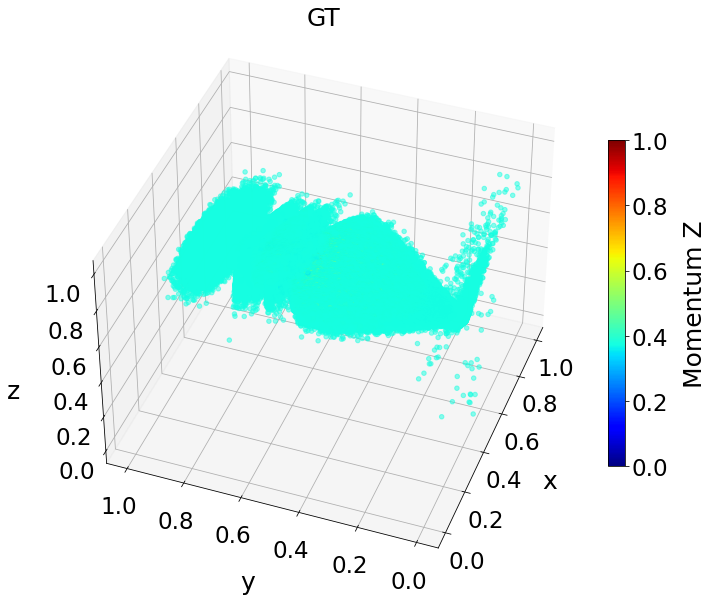

In [24]:
plot_3D(particle_tensor)

### Plot particle cloud by slices

In [29]:
pc = particle_tensor
slice_along = 2 #z: 2
num_slices = 10

slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

for ind in range(len(slices)-1):
    pc_[:, -1][(pc_[:, -3]>=slices[ind]) & (pc_[:, -3]<=slices[ind+1])] = ind
pc_[:, -1][(pc_[:, -3]>=slices[-1])] = len(slices) - 1

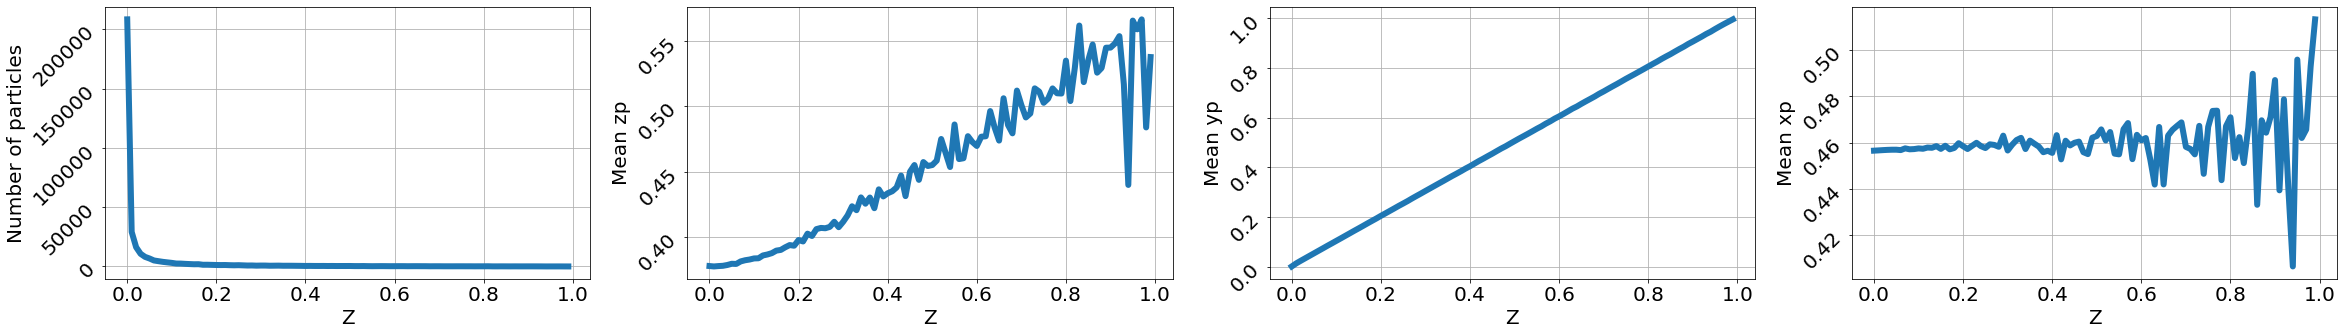

In [31]:
pc = particle_tensor
slice_along = 2 #z: 2
num_slices = 100
comp_of_interest = -3
figsize1 = 40
figsize2 = 5

labels_x = ['x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp']

fig, axs = plt.subplots(1, 4, figsize=(figsize1,figsize2))
plot_per_slice(axs=axs[0], comp_of_interest=None, 
                num_slices=num_slices, pc=particle_tensor, slice_along=slice_along)
for i in range(1,4,1):
    plot_per_slice(axs=axs[i], comp_of_interest=-1*i, 
                num_slices=num_slices, pc=particle_tensor, slice_along=slice_along, label='Mean ' + labels_y[-1*i])
plt.show()

### Plot 2D projection in (pos, momentum) plane

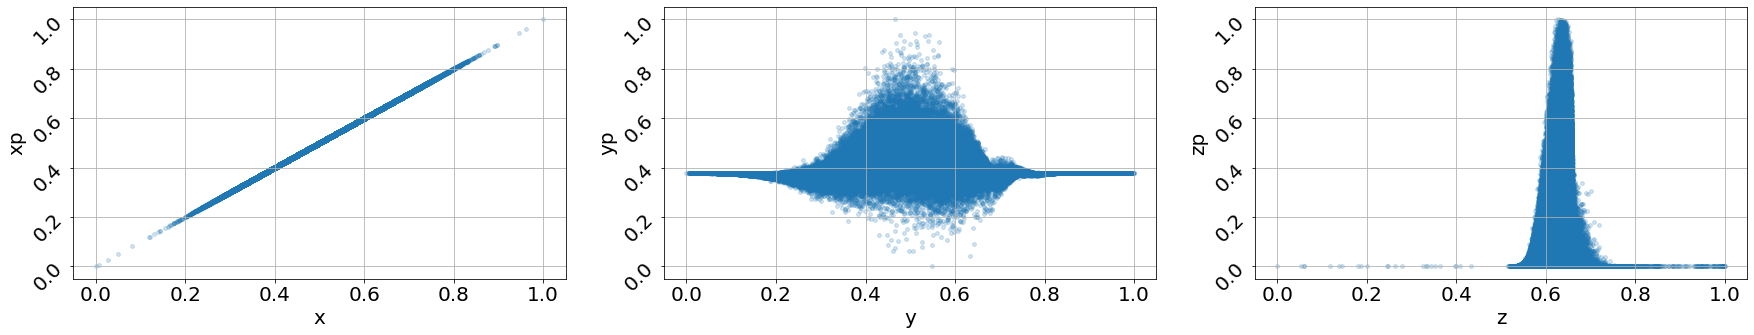

In [32]:
figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
labels_x = ['x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp']

for i in range(3):
    plot_2D(axs=axs[i], comp_x=i, comp_y=0-i,
            pc=particle_tensor, label_x=labels_x[i], label_y=labels_y[i])
plt.show()